In [5]:
import numpy as np
import sklearn
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
% matplotlib inline

import sys
print(sys.version_info)
print(np.__version__)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
1.12.1


In [6]:
def make_sin(n_samples=400, n_discr_points = 10):
    x = np.arange(start=0.0, stop=2.0*np.pi, step=2.0*np.pi/n_discr_points)
    omega = np.random.uniform(1.0, 4.0, (n_samples, x.shape[0]) )
    return np.sin(omega*x)

In [7]:
def make_sum(n_samples=600, n_discr_points=5):
    Y = np.random.randint(low=0,high=2,size=(n_samples,n_discr_points-1))
    Y = np.c_[Y, np.sum(Y, axis=1)]
    return Y

In [8]:
n_samples = 600
n_discr_points = 8
y = make_sum(n_samples, n_discr_points)
print (y.shape)

(600, 8)


In [9]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split( y, test_size=0.33, random_state=42 )
print(y_train.shape)
print(y_test.shape)

(402, 8)
(198, 8)


In [10]:
n_hidden_neurons = [8,5]
n_hidden_layers = len(n_hidden_neurons)
nlayers = n_hidden_layers+2

In [11]:
unroll_factor = n_discr_points - 1

In [12]:
class MeanSquareError():
        
    def error(self, y, a):
        return (a-y)**2
    
    def derror(self,a, y):
        return 2*(a-y)

In [13]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [160]:
class RecurrentInputLayer():
    """Designed to be compatible with Recurrent layers"""
    def __init__(self, n=2, unroll_fac=1):
        self.N = n
        self.unroll_ = unroll_fac
        self.h = np.zeros(shape=(n,self.unroll_+1))
    def forward(self, x, tt):
        self.h[:,tt+1] = np.array(x).reshape(self.N, 1)
        return self.h[:,tt+1]

In [161]:
class OutputLayer():
    def __init__(self, n=1, nprev=5, cost=MeanSquareError() ):
        self.N = n
        self.Nprev = nprev
        
        self.z = np.zeros(shape=(n,1))
        
        self.b = np.random.uniform(low=0., high=1., size=(n,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(n,nprev))
        self.Wupdates = np.zeros_like(self.W)
        
        self.cost_ = cost
        
    def forward(self, x, tt=0):
        self.z = (self.W @ x).reshape(self.N,1) + self.b
        return self.z
    
    def backward(self, y):
        return self.cost_.derror(self.z,y), self.cost_.derror(self.z,y)*self.W
        
    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates
        self.bupdates = np.zeros_like(self.b)
        self.Wupdates = np.zeros_like(self.W)

In [162]:
class RecurrentSigmoidLayer():
    def __init__(self, n=5, nprev=5, unroll_fac=1):
        self.N = n
        self.Nprev = nprev
        self.unroll_ = unroll_fac
        
        self.h = np.random.uniform(low=0., high=1., size=(self.N,self.unroll_+1))
        
        self.b = np.random.uniform(low=0., high=1., size=(self.N,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(self.N,self.Nprev))
        self.Wupdates = np.zeros_like(self.W)
        
        self.Whh = np.random.uniform(low=0., high=1., size=(self.N,self.N))
        self.Whhupdates = np.zeros_like(self.Whh)
        
    def forward(self, x, tt):
        
        x = np.array([x])
        x = x.reshape(self.Nprev, 1)
        
        self.h[:,tt+1] = sigmoid( np.ravel(
                          self.W @ x + self.Whh @ self.h[:,tt].reshape(self.N,1) + self.b) )            
   
        return self.h[:,tt+1]
    
    def backward(self, deltaL, deltaH, tt):
        
        delta = deltaL + deltaH
        delta = delta.reshape(1,self.N)
        h = self.h[:,tt+1].reshape(1,self.N)
        
        update_fac = delta * h * (1. - h)

        Ldelta = ( delta * h * (1. - h) ) @ self.W

        Hdelta =(  delta * h * (1. - h) ) @ self.Whh    

        return update_fac, Ldelta, Hdelta


    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates
        self.Whh -= self.Whhupdates
        self.bupdates = np.zeros_like(self.b)
        self.Wupdates = np.zeros_like(self.W)        
        self.Whhupdates = np.zeros_like(self.Whh)

In [163]:
CostFunction = MeanSquareError()

In [170]:
layers = []
layers.append( RecurrentInputLayer(1,unroll_factor) )
nprev = 1
for n in n_hidden_neurons:
    layers.append(RecurrentSigmoidLayer(n, nprev, unroll_factor))
    nprev = n
layers.append(OutputLayer(1,nprev,CostFunction))

In [171]:
alpha = 0.1
n_epochs = 10

training_error = []
validation_error = []
    
for i in range(n_epochs):

    errors = []
    for idx, data_sample in enumerate(y_train):
        
        # feedforward
        for t in range(unroll_factor):
            a = data_sample[t]
            for i in range(0,nlayers):
                a = layers[i].forward(a,t)

        # now a holds the prediction for the next value
        # the true next value is data_sample[unroll_factor]
        errors.append(CostFunction.error(data_sample[unroll_factor], a))
    
        ###########################################
        # backprop through time
        
        # output layer: no time        
        update_fac, delta = layers[nlayers-1].backward(data_sample[unroll_factor])     
        layers[nlayers-1].Wupdates = \
            alpha*np.outer(update_fac, layers[nlayers-2].h[:,-1] )
        layers[nlayers-1].bupdates = alpha*update_fac   
        
        # deltaL_dict[l][t] is the error signal that layer l passes to layer (l-1) at time t
        # deltaH_dict[l][t] is the error signal that layer l passes to itself from time t to t-1
        deltaL_dict = dict()
        deltaH_dict = dict()
        for l in range(nlayers-1,0,-1):
            deltaL_dict[l] = dict()
            deltaH_dict[l] = dict()
            for t in range(unroll_factor,-1,-1):
                deltaL_dict[l][t] = np.zeros( shape=(1, layers[l].Nprev) )
                deltaH_dict[l][t] = np.zeros( shape=(1, layers[l].N) )

        deltaL_dict[nlayers-1][unroll_factor-1] = delta
        
        for l in range(nlayers-2,0,-1):
            for t in range(unroll_factor-1,-1,-1):
                update_fac, Ldelta, Hdelta = layers[l].backward(deltaL_dict[l+1][t], deltaH_dict[l][t+1], t)
                deltaL_dict[l][t] = Ldelta
                deltaH_dict[l][t] = Hdelta
                layers[l].Wupdates   += alpha*np.outer(update_fac, layers[l-1].h[:,t+1] )
                layers[l].Whhupdates += alpha*np.outer(update_fac, layers[l].h[:,t] )
                layers[l].bupdates   += alpha*update_fac.reshape(layers[l].bupdates.shape[0],
                                                                 layers[l].bupdates.shape[1])
                   
        for i in range(1,nlayers):
            layers[i].update()
            
    training_error.append(np.mean(errors))
    
    # validation
    errors = []
    for idx, data_sample in enumerate(y_test):
        # feedforward
        for t in range(unroll_factor):
            a = data_sample[t]
            for i in range(0,nlayers):
                a = layers[i].forward(a,t)
        errors.append(CostFunction.error(data_sample[unroll_factor], a[0]))
    validation_error.append(np.mean(errors))

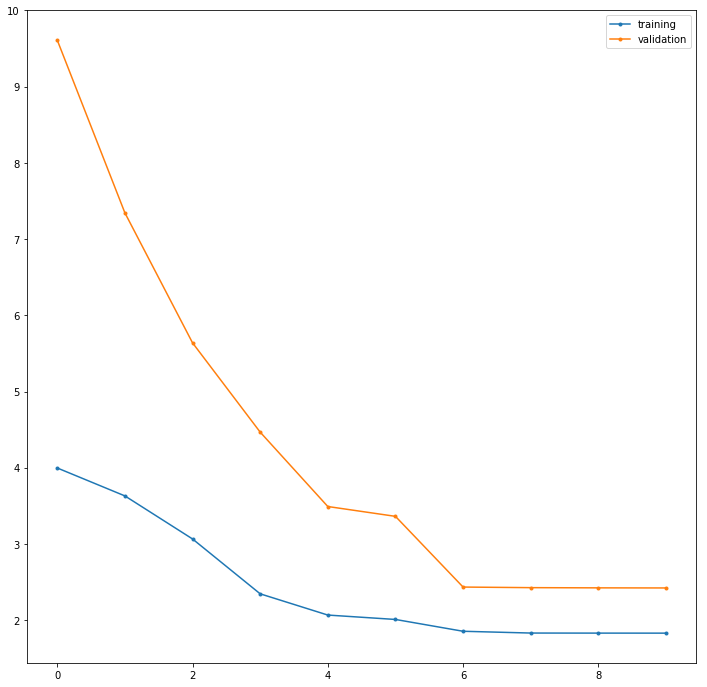

In [172]:
plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), training_error, '.-')
plt.plot(range(n_epochs), validation_error, '.-')
plt.legend(['training','validation'])

In [ ]:
def inference(layers, data_sample):
    # feedforward
    for t in range(unroll_factor):
        a = layers[0].forward(data_sample[t])
        for i in range(1,nlayers):
            a = layers[i].forward(a,t)
    return a

In [ ]:
for i in range(15):
    print(y_test[i,:])
    print(inference(layers,y_test[i,:]))